In [33]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.models import load_model

In [34]:
mat = scipy.io.loadmat('DMP_3.mat')
#q = mat['DMP'][0][0][0]
#p = mat['DMP'][0][0][1]
target = np.concatenate(mat['DMP'][0][0][2])
#time = np.concatenate(mat['DMP'][0][0][3])

data = np.loadtxt('data_collector/demo1.txt', skiprows = 1, delimiter = ',')

q = np.array(data[:,1:8])
target = q[-1]
q = q[:-1]
time = data[:-1, 0]

In [108]:
def psiF(h, c, s, i):
    return np.exp(-h[i]*(s-c[i])**2)


def DynamicMotionPrimitive(x, time, convert, target):
    time = time / convert  # Scale down time
    time = time - time[0]  # Make sure t[0] = 0
    dtx = np.diff(time)[0]  # TODO: should be dt
    dx = np.concatenate([[0], np.diff(x)]) / dtx  # Generate velocities
    ddx = np.concatenate([[0], np.diff(dx)]) / dtx  # Generate accelerations
    x0 = x[0]
    gx = x[-1]
    h = 1

    par = {}
    par['ng'] = 100
    par['h'] = np.concatenate(np.ones((1, par['ng'])) * h)
    par['s'] = 1
    par['as'] = 5
    par['tau'] = time[-1]
    par['K'] = 40000
    par['D'] = 100

    stime = []
    sE_x = np.array([])
    ftarget = np.array([])

    for i in range(0, len(time)):  # TODO: check end
        t = time[i]
        s = np.exp((-1 * par['as'] * t) / par['tau'])
        stime.append(s)
        ftar_tmp = (-1 * par['K'] * (gx - x[i]) + par['D'] * dx[i] + par['tau'] * ddx[i]) / (gx - x0)
        ftarget = np.append(ftarget, ftar_tmp)
        sE_x = np.append(sE_x, s * (gx - x0))

    # Calculate gaussian parameters
    # TODO: check if stime is in order, or err, smallest first largest last
    incr = (max(stime) - min(stime)) / (par['ng'] - 1)  # TODO: replace w/ index based min/max
    c = np.arange(min(stime), max(stime) + incr, incr)  # TODO: compare outputs
    lrc = c[::-1]
    ctime = (-1 * par['tau'] * np.log(lrc)) / par['as']
    d = np.diff(c)  # TODO: lc
    c = c / d[0]  # TODO: lc
    par['c'] = c
    w_x = []

    # Regression
    for i in range(0, par['ng']):  # TODO: possibly add one, needs to go to 100

        psV_x = []
        for j in range(0, len(time)):  # TODO: may not go to end
            psV_x.append(psiF(par['h'], par['c'], stime[j] / d[0], i))
        psV_x = np.array(psV_x)

        w_x.append((np.dot(sE_x[np.newaxis], np.dot(np.diag(psV_x),(ftarget[np.newaxis]).T)))
                   / np.dot((sE_x[np.newaxis]), np.dot(np.diag(psV_x), sE_x[np.newaxis].T)))

    # store results
    r = par
    r['length'] = len(time)
    r['time'] = time
    r['stime'] = stime
    r['ftarget'] = ftarget
    r['w_x'] = w_x
    r['x0'] = x0
    r['gx'] = gx
    r['d0'] = d[0]
    r['dt'] = dtx
    r['ctime'] = ctime

    # generate est. DMP

    f_replay_x = []
    fr_x_zeros = []

    # TODO: check usage
    ydd_x_r = 0
    yd_x_r = 0
    y_x_r = r['x0']

    ydd_xr = []
    yd_xr = []
    y_xr = []

    for j in range(0, len(r['time'])):  # TODO check if reaches end
        psum_x = 0
        pdiv_x = 0
        for i in range(0, r['ng']):  # TODO check what i is doing in psiF below
            psum_x += psiF(r['h'], r['c'], r['stime'][j] / r['d0'], i) * r['w_x'][i]
            pdiv_x += psiF(r['h'], r['c'], r['stime'][j] / r['d0'], i)

        # Generate new trajectories according to new control input
        f_replay_x.append((psum_x / pdiv_x) * r['stime'][j] * (target - r['x0']))

        if j > 0:  # TODO: check
            if np.sign(f_replay_x[j - 1]) != np.sign(f_replay_x[j]):
                fr_x_zeros.append(j - 1)  # TODO: lc

        ydd_x_r = (r['K'] * (target - y_x_r) - (r['D'] * yd_x_r) + (target - r['x0']) * f_replay_x[j]) / r['tau']
        yd_x_r = yd_x_r + (ydd_x_r * dtx) / r['tau']
        y_x_r = y_x_r + (yd_x_r * dtx) / r['tau']

        ydd_xr.append(ydd_x_r)
        yd_xr.append(yd_x_r)
        y_xr.append(y_x_r)

    results = {}
    results['ydd_xr'] = ydd_xr
    results['yd_xr'] = yd_xr
    results['y_xr'] = y_xr
    results['fr_x_zeros'] = fr_x_zeros
    results['f_replay_x'] = f_replay_x

    return results

(1242, 7)
(1242, 3)
(7,)
(1242,)
(1242, 3)


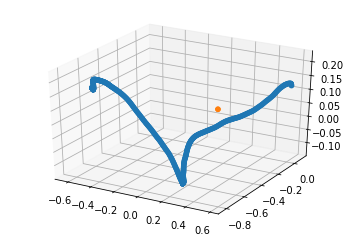

In [109]:

fm = load_model('models/fm.h5')


p = fm.predict(q)/100

print(q.shape)
print(p.shape)
print(target.shape)
print(time.shape)
DMP_res = []
for i in range(0, 1):
    temp = []
    for j in range(0, len(q[0])):
        targ = target[j]
        result = DynamicMotionPrimitive(q[:, j], time, 1000, targ)
        # TODO: missing line temp(:,j) = results['y_xr
        DMP_res.append(result['y_xr'])  # changed bc missing above line

DMP_res = np.array(DMP_res)
#print(DMP_res.shape)
    
    
cart = fm.predict(np.squeeze(DMP_res).T)/100       

print(cart.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p[:,0], p[:,1], p[:,2], 'b')
ax.scatter(cart[0]/4500, cart[1]/4500, cart[2]/4500, 'r')
plt.show()


In [46]:
a = np.squeeze(DMP_res)

In [48]:
(a.T).shape

(1242, 7)

In [53]:
print(cart.shape
     )

(1242, 3)


In [57]:
print(cart/10)

[[ 0.00195645 -0.04604204  0.08143535]
 [-0.03274361 -0.05036771  0.0705578 ]
 [-0.04026286 -0.07455084  0.06946242]
 ...
 [ 0.6454637  -0.4002501   1.6399844 ]
 [ 0.63806176 -0.40538326  1.6447163 ]
 [ 0.6297271  -0.40996417  1.6477156 ]]


In [67]:
print(np.squeeze(DMP_res).T[:,0])

[ -1.7377334   -5.00999443  -9.84441833 ... -94.23077189 -94.06050182
 -93.90011962]


(1242,)
(1242,)


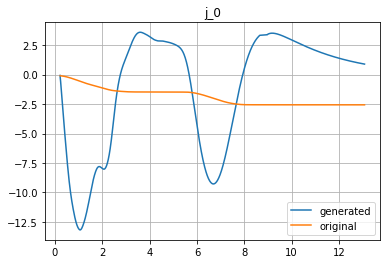

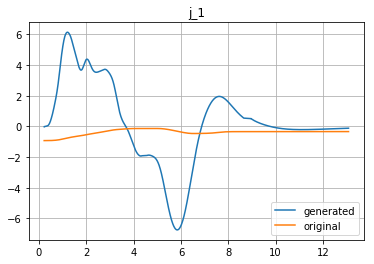

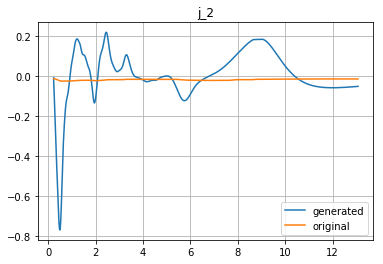

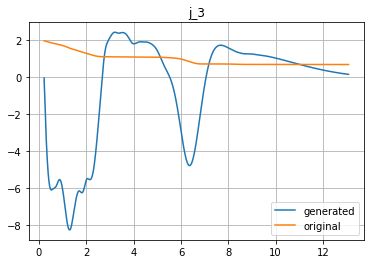

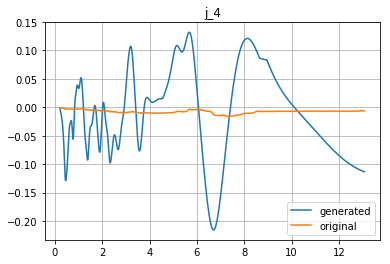

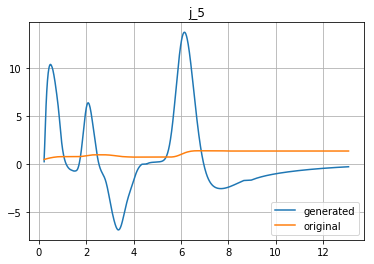

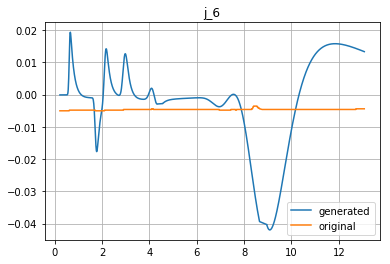

In [110]:
print(p[:,0].shape)
print(time.shape)

for i in range(0, 7):
    plt.figure()
    plt.title("j_%d" % i)
    plt.plot(time, np.squeeze(DMP_res).T[:,i]/45, label="generated")
    plt.plot(time, q[:,i], label="original")
    plt.grid()
    plt.legend(loc="lower right")
    plt.show()